# DNN Sample Code (MNIST)

## data preparation

In [1]:
import cPickle as pkl
import os, sys
import numpy as np
import tensorflow as tf
import math

we have sampled mnist data at ./data folder
- image file : np_image_file.10k.pkl  <-- pickled objects
- label file : np_label_file.10k.pkl  <-- pickled objects

a image of minst is 28x28 pixel image

In [2]:
# loading and checking

with open('./data/np_image_file.10k.pkl') as image_f:
    images = pkl.load(image_f)

with open('./data/np_label_file.10k.pkl') as label_f:
    labels = pkl.load(label_f)    

In [3]:
type(images)
print images.shape
print len(images)
print len(images[0])

type(labels)
print labels.shape
print labels[0]

(10000, 784)
10000
784
(10000,)
7


### sample image

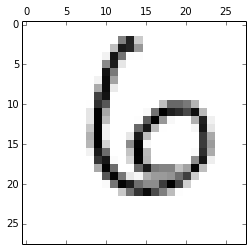

In [4]:
# from https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/mnist.py
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(an_image, shape=[28,28]):
    sample_image = 1.0 - np.reshape(an_image, shape)

    # gray map : 1.0 --> black, 0.0 --> white
    plt.matshow(sample_image, cmap=plt.cm.gray)
    plt.show()    
    
an_image = images[100]
show_image(an_image)

## data reader (batch-wise)

In [5]:
batch_size = 100
def batch_reader(start_index):
    # read data[start_index:start_index+batch_size]
    # return [batch_size, 784], [batch_size]
    try:
        batch_images = images[start_index:start_index+batch_size]
        batch_labels = labels[start_index:start_index+batch_size]
        return np.array(batch_images), batch_labels
    except:
        return None, None
# check

## Inference Graph

In [6]:
def variable_init_2D(num_input, num_output):
    """
    Initialize weight matrix using truncated normal method
      check detail from Lecun (98) paper.
       - http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf
    """
    init_tensor = tf.truncated_normal([num_input, num_output], stddev=1.0 / math.sqrt(float(num_input)))
    return init_tensor

def inference(batch_input):
    # batch_input : [batch_size, input_dim]  # ex) mnist case : 784
    
    # do inference & and return logits
    # return [batch_size, 10]   # 10 = [0,1,2,....,9]

    # 3 layer 
    # 784 --> 128 --> 32
    input_dim = 784
    h1_dim = 144
    h2_dim = 36
    output_dim = 10
    with tf.variable_scope("hidden_1"):
        W = tf.Variable( variable_init_2D(input_dim, h1_dim), name='weights')
        b = tf.Variable( tf.zeros([h1_dim]), name='biases')
        out_h1 = tf.nn.relu( tf.matmul(batch_input, W) + b )
    
    with tf.variable_scope("hidden_2"):
        W = tf.Variable( variable_init_2D(h1_dim, h2_dim), name='weights')
        b = tf.Variable( tf.zeros([h2_dim]), name='biases')
        out_h2 = tf.nn.relu( tf.matmul(out_h1, W) + b )
    
    with tf.variable_scope("hidden_3"):
        W = tf.Variable( variable_init_2D(h2_dim, output_dim), name='weights')
        b = tf.Variable( tf.zeros([output_dim]), name='biases')
        
        # no activation at final layer
        out_h3 = tf.matmul(out_h2, W) + b
        
    return out_h1, out_h2, out_h3

# check
b_image, _ = batch_reader(0)
inference(b_image)

(<tf.Tensor 'hidden_1/Relu:0' shape=(100, 144) dtype=float32>,
 <tf.Tensor 'hidden_2/Relu:0' shape=(100, 36) dtype=float32>,
 <tf.Tensor 'hidden_3/add:0' shape=(100, 10) dtype=float32>)

## Loss Graph

In [7]:
def loss(batch_logits, batch_ref):
    # batch_logits : inference result [batch_size, output_dim] ex) mnist case : output_dim =10
    # batch_ref    : reference        [batch_size]
    
    
    # calculate loss
    # from : https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#sparse_softmax_cross_entropy_with_logits
    
    _batch_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(batch_logits, batch_ref)
    
    # return : scala_value
    # loss collapsed! (batch-wise)
    _loss = tf.reduce_mean(_batch_loss)
    return _loss
   
    

## Parameter Update Graph

In [8]:
def updator(loss_op):
    # do update for minimizing loss from loss_op
    #
    
    opt = tf.train.GradientDescentOptimizer
    #opt = tf.train.AdamOptimizer
    
    optimizer = opt(learning_rate=0.1)
    update_op = optimizer.minimize(loss_op)
    
    return update_op



## Graph Connection && Placeholder

In [9]:
# placeholder for batch input & output
pl_batch_input = tf.placeholder(tf.float32, shape=(batch_size, 784), name='pl_image')
pl_batch_ref   = tf.placeholder(tf.int32,   shape=(batch_size),      name='pl_label')

# check
print pl_batch_input
print pl_batch_ref

Tensor("pl_image:0", shape=(100, 784), dtype=float32)
Tensor("pl_label:0", shape=(100,), dtype=int32)


In [10]:
# flow : inference --> loss --> updator --> training loop
_, _, batch_logits = inference(pl_batch_input)    # batch_input <-- will be placed
loss_op = loss(batch_logits, pl_batch_ref)        # batch_ref <--- will be placed 
updator_op = updator(loss_op)

# check
print batch_logits
print loss_op
print updator_op

Tensor("hidden_3_1/add:0", shape=(100, 10), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_hidden_1_1/weights/ApplyGradientDescent"
input: "^GradientDescent/update_hidden_1_1/biases/ApplyGradientDescent"
input: "^GradientDescent/update_hidden_2_1/weights/ApplyGradientDescent"
input: "^GradientDescent/update_hidden_2_1/biases/ApplyGradientDescent"
input: "^GradientDescent/update_hidden_3_1/weights/ApplyGradientDescent"
input: "^GradientDescent/update_hidden_3_1/biases/ApplyGradientDescent"



## Initalize Session

In [11]:
sess = tf.Session()
# init all variable before training loop
init_op = tf.initialize_all_variables()
sess.run(init_op)

## Training Loop

In [12]:
epoch = 0
step = 0 
start_index = 0
print "batch_size : ", batch_size
epoch_losses = []
while True:
    if epoch > 100: break
    step += 1
    
    ## --- every step ----
    ## do params. update batchwise
    batch_input, batch_refs = batch_reader(start_index)
    if len(batch_input) < 1 : 
        # epoch is finished
        epoch += 1
        start_index = 0
        print "\t >> Epoch Step {} loss {}".format(epoch, np.mean(epoch_losses))
        epoch_losses = []
        continue 
    
    feed_dict = {
                    pl_batch_input : batch_input,
                    pl_batch_ref   : batch_refs,
                }
    loss_value, _ = sess.run( [loss_op, updator_op], 
                             feed_dict=feed_dict
                            )
    """if step % 10 == 0: 
        print "Epoch : {} Step : {} Loss : {}".format(epoch, step, loss_value)
    """
    epoch_losses.append( loss_value ) 
    
        
    start_index += batch_size 

batch_size :  100
	 >> Epoch Step 1 loss 1.27505600452
	 >> Epoch Step 2 loss 0.448837518692
	 >> Epoch Step 3 loss 0.340164273977
	 >> Epoch Step 4 loss 0.287963986397
	 >> Epoch Step 5 loss 0.251861542463
	 >> Epoch Step 6 loss 0.223167270422
	 >> Epoch Step 7 loss 0.199447855353
	 >> Epoch Step 8 loss 0.178755223751
	 >> Epoch Step 9 loss 0.160903334618
	 >> Epoch Step 10 loss 0.144714295864
	 >> Epoch Step 11 loss 0.130465477705
	 >> Epoch Step 12 loss 0.117829665542
	 >> Epoch Step 13 loss 0.106353327632
	 >> Epoch Step 14 loss 0.0963449850678
	 >> Epoch Step 15 loss 0.0873490124941
	 >> Epoch Step 16 loss 0.0793978795409
	 >> Epoch Step 17 loss 0.0729095339775
	 >> Epoch Step 18 loss 0.0684738606215
	 >> Epoch Step 19 loss 0.0617712587118
	 >> Epoch Step 20 loss 0.05501909554
	 >> Epoch Step 21 loss 0.0498677715659
	 >> Epoch Step 22 loss 0.0448025763035
	 >> Epoch Step 23 loss 0.0398697406054
	 >> Epoch Step 24 loss 0.035295329988
	 >> Epoch Step 25 loss 0.0314673483372
	 >> Epo